***EXERCISE 1 - BUILD A CLASSIFIER FOR THE MNIST DATASET THAT ACHIEVES OVER 97% ACCURACY ON THE TEST SET***

In [1]:
from scipy.io import arff
import pandas as pd
import os

data = arff.loadarff('%s/Downloads/mnist_784.arff'%os.environ['HOME'])
df = pd.DataFrame(data[0])
df.shape

(70000, 785)

In [5]:
X, y_raw = df.copy(), df['class']
X.drop('class',axis=1,inplace=True)

# Convert dtype of y to strings
y = y_raw.to_numpy('str')
print(X.shape)
print(y.shape)

(70000, 784)
(70000,)


In [6]:
# Split into training and test sets - NOTE: MNIST is already shuffled
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

Build a classifier that achieves > 97% accuracy

In [3]:
# Consider a KNeighborsClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

# Grid search on weights and n_neighbors hyperparameters
param_grid = [
    {'n_neighbors': [3,4,5,6], 'weights': ['uniform', 'distance'] }
]

# Init the classifier
knn_clf = KNeighborsClassifier()

# Create the grid_search
grid_search = GridSearchCV(knn_clf, param_grid, cv=5, verbose=True)

In [7]:
# Run the grid search - this takes awhile
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 8 candidates, totalling 40 fits


KeyboardInterrupt: 

In [8]:
# If opening notebook from a previous session wherein grid_search has been run,
# simply set grid_search's best_params_. Otherwise, fetch best_params_ from instance above

grid_search.best_params_ = {'n_neighbors': 4, 'weights': 'distance'}
#grid_search.best_params_

In [13]:
cv_results = grid_search.cv_results_

In [16]:
import numpy as np

for mean_score, params in zip(cv_results['mean_test_score'], cv_results['params']):
    print(np.sqrt(mean_score), params)

0.9849196244702746 {'n_neighbors': 3, 'weights': 'uniform'}
0.9854525187276485 {'n_neighbors': 3, 'weights': 'distance'}
0.9841239759298622 {'n_neighbors': 4, 'weights': 'uniform'}
0.9857061766402129 {'n_neighbors': 4, 'weights': 'distance'}
0.9845218805762184 {'n_neighbors': 5, 'weights': 'uniform'}
0.9850972879196586 {'n_neighbors': 5, 'weights': 'distance'}
0.9839207285142436 {'n_neighbors': 6, 'weights': 'uniform'}
0.9855117114135851 {'n_neighbors': 6, 'weights': 'distance'}


In [7]:
# Best hyperparameters are:
#.  n_neighbors = 4
#.  weights = 'distance'
from sklearn.model_selection import cross_val_predict

# Now create a classifier with these parameters and fit to training data
knn_clf_best = KNeighborsClassifier(n_neighbors=4,weights='distance')

# Instead of fitting the test set, let's fit the training set via cross-validation
# This will give a sense of performance of classifier before applying it to test set
y_train_knn_clf_best = cross_val_predict(knn_clf_best, X_train, y_train, cv=5)

In [8]:
# Assess accuracy of knn_clf_best
from sklearn.metrics import accuracy_score

# Accuracy exceeds 97%! 
accuracy_score(y_train, y_train_knn_clf_best)

0.9716166666666667

In [9]:
# Now fit the knn_clf_best classifier
knn_clf_best.fit(X_train,y_train)

KNeighborsClassifier(n_neighbors=4, weights='distance')

In [10]:
# Predict on the test set
pred = knn_clf_best.predict(X_test)

# Report accuracy without snooping the test set
print("Accuracy of knn_clf_best classifier on test set = %.2f %%"%
     (accuracy_score(y_test,pred)*100))

Accuracy of knn_clf_best classifier on test set = 97.14 %


***EXERCISE 2 - DATA AUGMENTATION: EXPAND MNIST DATASET BY SHIFTING IMAGES ONE PIXEL LEFT/RIGHT/UP/DOWN***

In [87]:
# Define a function to shift an image by one pixel up, down, left, or right
from scipy.ndimage.interpolation import shift
import matplotlib.pyplot as plt
import pandas as pd

def shiftDigit(digit,by=''):
    # Reshape the digit represented as a pandas series
    d = digit.values.reshape(28,28)
    
    # How to shift the digit
    if by == 'r':
        augDigit = shift(d, [0, 1], cval=0)
    elif by == 'l':
        augDigit = shift(d, [0, -1], cval=0)
    elif by == 'u':
        augDigit = shift(d, [-1, 0], cval=0)
    elif by == 'd':
        augDigit = shift(d, [1, 0], cval=0)
    else:
        raise ValueError("Invalid shift by control : %s"%by)
    
    return pd.Series(augDigit.reshape(28*28))

def showDigit(digit):
    plt.imshow(digit.values.reshape(28,28),cmap='binary')

/tmp/ipykernel_21057/335493721.py:2: DeprecationWarning: Please use `shift` from the `scipy.ndimage` namespace, the `scipy.ndimage.interpolation` namespace is deprecated.
  from scipy.ndimage.interpolation import shift


In [97]:
# Expand the labels; since shifted images correspond to same labels, simply duplicate the labels
import numpy as np
y_train_expand = np.concatenate((y_train,y_train,y_train,y_train,y_train))
y_train_expand.shape

(300000,)

In [88]:
# Shift each digit in training set left/right/up/down
X_train_l = X_train.copy()
X_train_r = X_train.copy()
X_train_u = X_train.copy()
X_train_d = X_train.copy()

In [94]:
# Apply shifting function
for i in range(X_train.shape[0]):
    X_train_l.iloc[i] = shiftDigit(X_train.iloc[i],by='l')
    X_train_r.iloc[i] = shiftDigit(X_train.iloc[i],by='r')
    X_train_u.iloc[i] = shiftDigit(X_train.iloc[i],by='u')
    X_train_d.iloc[i] = shiftDigit(X_train.iloc[i],by='d')

X_train_expand = pd.concat([X_train, X_train_l, X_train_r, X_train_u, X_train_d],axis=0)

In [99]:
# Fit the knn_clf_best classifier from exercise 1 to the expanded set
X_train_expand.shape, y_train_expand.shape

knn_clf_best.fit(X_train_expand, y_train_expand)

KNeighborsClassifier(n_neighbors=4, weights='distance')

In [102]:
# Apply trained knn_clf_best on original test set
pred_expand = knn_clf_best.predict(X_test)
print("Accuracy of knn_clf_best classifier on test set = %.2f%%"%(accuracy_score(y_test,pred_expand)*100))

Accuracy of knn_clf_best classifier on test set = 97.63%


In [103]:
#####
# Augmenting the data only led to ~0.5% increase in accuracy when applied to the test set
#####

***EXERCISE 3 - THE TITANIC DATASET***

In [75]:
import os
import pandas as pd

titanic_test = pd.read_csv('%s/kaggle/datasets/titanic/test.csv'%os.environ['HOME'])
titanic_train_raw = pd.read_csv('%s/kaggle/datasets/titanic/train.csv'%os.environ['HOME'])

# Report columns with NaNs
def colNan(data):
    for c in data.columns:
        if data[c].isnull().values.any():
            cntNull=data[c].isnull().sum()
            print("%s has %i NaNs, representing %.2f%% of total"%
                  (c,cntNull,(100*cntNull/len(data[c]))))

colNan(titanic_train_raw)

Age has 177 NaNs, representing 19.87% of total
Cabin has 687 NaNs, representing 77.10% of total
Embarked has 2 NaNs, representing 0.22% of total


In [61]:
# With a substantial portion of 'Cabin' attributes being NaN, consider dropping the column all together.
# 'Age' and 'Embarked' features are NaN < 20% and < 1%, respectively. So consider
# using an imputer to replace missing 'Age' values with mean or median of said column,
# and drop DataFrame indices where Embarked is NaN.

# Drop 'Cabin' & 'Name', as the latter is conceivably irrelevant to survival
titanic_train_raw = titanic_train_raw.drop(['Cabin','Name'],axis=1)
titanic_train_raw.dropna(subset=['Embarked'],inplace=True)

In [62]:
# Extract the 'Survived' column from titanic_train_raw to use as labels
titanic_train_labels = titanic_train_raw.Survived
titanic_train = titanic_train_raw.drop(['Survived'], axis=1)

# Set the PassengerId as index
titanic_train.set_index('PassengerId',inplace=True)

# Shapes of train/test data
print(titanic_train.shape, titanic_train_labels.shape, titanic_test.shape)
titanic_train.head()

(889, 8) (889,) (418, 11)


,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
PassengerId,,,,,,,,
1,3,male,22.0,1,0,A/5 21171,7.2500,S
2,1,female,38.0,1,0,PC 17599,71.2833,C
3,3,female,26.0,0,0,STON/O2. 3101282,7.9250,S
4,1,female,35.0,1,0,113803,53.1000,S
5,3,male,35.0,0,0,373450,8.0500,S


In [63]:
# # Transform missing values in 'Age' & 'Fare' features using mean imputer
# M = mean_imputer.transform(titanic_train_numeric)

# # Convert result to a DataFrame and map columns to titanic_train
# titanic_train_numeric_filled = pd.DataFrame(M, columns=titanic_train_numeric.columns,
#                                            index=titanic_train_numeric.index)

# titanic_train.Age = titanic_train_numeric_filled.Age
# titanic_train.Fare = titanic_train_numeric_filled.Fare

# titanic_train.head()

In [64]:
# Isolate categorical features & describe
titanic_train_cat = titanic_train.drop(['Pclass','Age','SibSp','Parch','Fare'], axis=1)
titanic_train_cat.Sex.describe(), titanic_train_cat.Ticket.describe(), titanic_train_cat.Embarked.describe()

(count      889
 unique       2
 top       male
 freq       577
 Name: Sex, dtype: object,
 count        889
 unique       680
 top       347082
 freq           7
 Name: Ticket, dtype: object,
 count     889
 unique      3
 top         S
 freq      644
 Name: Embarked, dtype: object)

In [65]:
# Make use of pipelines
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

# Define numerical and categorical attributes
num_attribs = ['Pclass', 'Age', 'SibSp', 'Parch', 'Fare']
cat_attribs = ['Sex', 'Embarked']

# Define pipeline for numerical attributes
numeric_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
])

# # Define pipeline for categorical attributes
# cat_pipe = Pipeline([
#     ('ohe', OneHotEncoder(), cat_attribs)
# ])

# Define a full pipeline for the columns
# Consider OneHotEncoder for Sex & Embarked attributes (each takes of discrete values w/ no inherent order)
full_pipe = ColumnTransformer([
    ('num', numeric_pipe, num_attribs),
    ('cat', OneHotEncoder(), cat_attribs),
])

titanic_train_prepared = full_pipe.fit_transform(titanic_train)

In [66]:
titanic_train_prepared[:5]

array([[ 3.    , 22.    ,  1.    ,  0.    ,  7.25  ,  0.    ,  1.    ,
         0.    ,  0.    ,  1.    ],
       [ 1.    , 38.    ,  1.    ,  0.    , 71.2833,  1.    ,  0.    ,
         1.    ,  0.    ,  0.    ],
       [ 3.    , 26.    ,  0.    ,  0.    ,  7.925 ,  1.    ,  0.    ,
         0.    ,  0.    ,  1.    ],
       [ 1.    , 35.    ,  1.    ,  0.    , 53.1   ,  1.    ,  0.    ,
         0.    ,  0.    ,  1.    ],
       [ 3.    , 35.    ,  0.    ,  0.    ,  8.05  ,  0.    ,  1.    ,
         0.    ,  0.    ,  1.    ]])

In [67]:
# Train a SGDClassifier
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=1)
sgd_clf.fit(titanic_train_prepared, titanic_train_labels)

SGDClassifier(random_state=1)

In [69]:
# Use trained model to predict the labels of training set, and look at accuracy
from sklearn.metrics import accuracy_score

predictions = sgd_clf.predict(titanic_train_prepared)
print("Trained SGDClassifier fit to prepared training data achieves %.2f%% accuracy"%
     (100*accuracy_score(titanic_train_labels,predictions)))

Trained SGDClassifier fit to prepared training data achieves 78.74% accuracy


In [70]:
# Consider cross validation to assess performance of sgd_clf
from sklearn.model_selection import cross_val_predict

fold_predictions = cross_val_predict(sgd_clf, titanic_train_prepared, titanic_train_labels, cv=5)

In [71]:
print(fold_predictions)

[0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 1
 0 0 1 1 1 0 1 0 0 1 1 0 1 0 1 0 0 0 1 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0
 1 1 0 1 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 1 0 0
 0 0 1 0 1 0 0 0 0 0 0 0 

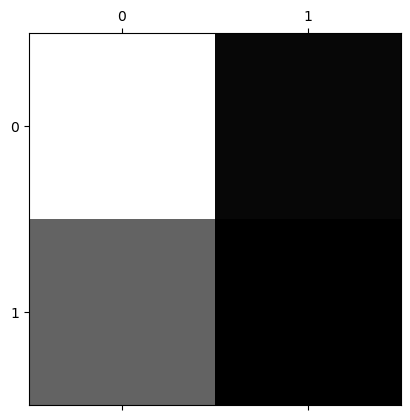

In [72]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

conf_mat = confusion_matrix(titanic_train_labels, fold_predictions)
plt.matshow(conf_mat, cmap=plt.cm.gray)

In [73]:
# Define function to generate results to submit
def results(ids,predictions):
    sub = pd.DataFrame({
                        'PassengerId': ids,
                        'Survived': predictions
                        }
    )
    
    sub.to_csv('submission.csv', index=False)

In [76]:
# Apply the same data preparation steps to the test set
titanic_test = titanic_test.drop(['Cabin','Name'],axis=1)
titanic_test.dropna(subset=['Embarked'],inplace=True)
titanic_test.set_index('PassengerId', inplace=True)

# Save index
indices = titanic_test.index

titanic_test_prepared = full_pipe.fit_transform(titanic_test)

results(indices, sgd_clf.predict(titanic_test_prepared))

***EXERCISE 4 - BUILD A SPAM CLASSIFIER***

In [1]:
import os
import tarfile
import urllib.request
import pandas as pd

ROOT = 'https://spamassassin.apache.org/old/publiccorpus/'
HAM = ROOT + '20030228_easy_ham.tar.bz2'
SPAM = ROOT + '20030228_spam.tar.bz2'
PATH = os.path.join('apache-datasets','spam')

def get_spam_n_ham(ham_url=HAM, spam_url=SPAM, path_to_data=PATH):
    if not os.path.isdir(path_to_data):
        os.makedirs(path_to_data)
    for file, url in [('ham.tar.bz2', ham_url), ('spam.tar.bz2', spam_url)]:
        path = os.path.join(path_to_data,file)
        if not os.path.isfile(path):
            # Download from url and place at path
            print("Extracting from : %s"%url)
            urllib.request.urlretrieve(url, path)
        tar_bz2 = tarfile.open(path)
        tar_bz2.extractall(path=path_to_data)
        tar_bz2.close()
        
        
get_spam_n_ham()

In [2]:
# Spam/ham examples are named according to <message #>.<MD5 sum>

# Set paths to spam and easy_ham
HAMPATH = os.path.join(os.getcwd(),'apache-datasets','spam','easy_ham')
SPAMPATH = os.path.join(os.getcwd(),'apache-datasets','spam','spam')

# Access names of each easy_ham and spam message
HAM = [os.path.join(HAMPATH,f) for f in os.listdir(HAMPATH) if os.path.isfile(os.path.join(HAMPATH,f)) and f != 'cmds']
SPAM = [os.path.join(SPAMPATH,f) for f in os.listdir(SPAMPATH) if os.path.isfile(os.path.join(SPAMPATH,f)) and f != 'cmds']

In [3]:
len(HAM), len(SPAM)

(2500, 500)

In [4]:
# Using the email module, define a function to parse the email messages
import email
from email import policy
from email.parser import BytesParser

def read_email(email):
    # Read the email file
    with open(email, 'rb') as file:
        # Parse the email content
        return BytesParser(policy=policy.default).parse(file)

In [5]:
# Read all the spam and ham emails
emails_ham = [read_email(e) for e in HAM]
emails_spam = [read_email(e) for e in SPAM]

In [6]:
# Peek at a ham email (removing leading/trailing whitespace)
emails_ham[0].get_content().strip()

"On a RH 8 box, I'm trying to install your package\nxine-0.9.13-fr5.i386.rpm, I keep running into dependency problems.  I've\ntried to install the dev and lib rpm's as well and they error out with\ndependency problems on each other (they each want something from the\nother's package).\n\nI've tried the --without options, but still end up with (similar for the\nregular package),\n\n\tglut is needed by xine-libs-0.9.13-fr5\n        aalib is needed by xine-libs-0.9.13-fr5\n        lirc is needed by xine-libs-0.9.13-fr5\n        libaa.so.1 is needed by xine-libs-0.9.13-fr5\n        libglut.so.3 is needed by xine-libs-0.9.13-fr5\n\nWhat am I missing here?\n\nThanks for your efforts.\nQuaffAPint\n\n\n\n\n\n\n_______________________________________________\nRPM-List mailing list <RPM-List@freshrpms.net>\nhttp://lists.freshrpms.net/mailman/listinfo/rpm-list"

In [7]:
# Peek at a spam email (removing leading/trailing whitespace)
emails_spam[1].get_content().strip()

'Earn Extra Income From Home. Here is tremendous\nopportunity to earn big money. We are a multimillion\ncompany that is growing at a rate of 1000% per year.\nWe are looking for motivated individuals who are\nlooking to earn a substantial income from home.\n\nThis is what you been waiting for a chance to be\nfinancially secure.  Earn Extra Income From Home. Here\nis a tremendous opportunity to earn\n No experience is required. We will provide the\ntraining you may need. \n\nWe are looking for energetic and self- motivated\npeople that want to change their life. If that is you\nclick the link below and complete our online\ninformation request form, and one of our employment\nspecialist will contact you.\n\nhttp://ter.netblah.com:27000\n\nGot nothing to lose and a lot to gain, with a career\nthat will provide you cast opportunities and\nsubstantial income. Please fill our online information\nrequest form here:\n\nhttp://ter.netblah.com:27000\n\nTo remove from our list simply click on the 

In [8]:
# Demonstrate utility of get_payload() and get_content_type()
print(emails_ham[1].get_content_type()) # email is a multipart/signed
print(emails_ham[1].get_payload()) # list of each EmailMessage object comprising multipart/signed email
print(emails_ham[1].get_payload(0).get_content_type()) # content_type of first EmailMessage object
print(emails_ham[1].get_payload(1).get_content_type())

multipart/signed
[<email.message.EmailMessage object at 0x7fd8a91026e0>, <email.message.EmailMessage object at 0x7fd8a9102860>]
text/plain
application/pgp-signature


In [9]:
# Some emails are more than just text...
# Namely, emails_spam[1].get_content().strip() returns: "KeyError: 'multipart/mixed'"

# Use get_payload() to return:
#   - list of email.message.EmailMessage objects when is_multipart()=True
#   - or a string when is_multipart()=False

# Define a function to determine an email's structure
def email_structure(email):
    # Immediately return if email is a simple string
    if isinstance(email, str):
        return email
    # Otherwise, use get_payload() to determine message parts
    components = email.get_payload()
    
    # Recursively call email_structure() and determine content_type of each piece of multipart
    if isinstance(components, list):
        return 'multipart({})'.format(', '.join([email_structure(c) for c in components]))
    else:
        return email.get_content_type()
        
    
# Collect the unique email structures for the ham and spam emails
uniq_structures_ham = [email_structure(email) for email in emails_ham]
uniq_structures_spam = [email_structure(email) for email in emails_spam]

# Unique ham structures
print(pd.Series(uniq_structures_ham).value_counts())
# Unique spam structures
print(pd.Series(uniq_structures_spam).value_counts())

text/plain                                                                                                                   2408
multipart(text/plain, application/pgp-signature)                                                                               66
multipart(text/plain, text/html)                                                                                                8
multipart(text/plain, text/plain)                                                                                               4
multipart(text/plain)                                                                                                           3
multipart(text/plain, application/octet-stream)                                                                                 2
multipart(text/plain, application/x-pkcs7-signature)                                                                            1
multipart(text/plain, video/mng)                                                          

# Observations
- While both spam and ham emails are mostly represented as text/plain, each set contains multipart emails too
- The multipart emails include
    - videos
    - images
    - html
    - etc.
- Of note, some spam email messages are simple text/html, while no ham email is just html

In [10]:
# emails_ham[0].keys()   : return list of all the message's header field names
# emails_ham[0].values() : return list of all the message's field values
# emails_ham[0].items()  : 2-tuples of keys/values of message's field headers and values

class VerboseEmail:     
    def set_email(self, email):
        self.email=email
        self.unixfrom=self.email.get_unixfrom()
        self.contentType=self.email.get_content_type()
        self.boundary=self.email.get_boundary()
        self.items=self.email.items()
        self._prefSuff_=' ---- '
        return self
    
    def _unixfrom_(self):
        return "%sUNIXFROM%s\n%s\n"%(self._prefSuff_, self._prefSuff_,
                                    self.unixfrom)
    
    def _content_(self):
        theContents=''
        if self.email.is_multipart():
            for part in self.email.walk():
                ctype = part.get_content_type()
                cdispo = str(part.get('Content-Disposition'))
                
                if ctype == 'text/plain' and 'attachment' not in cdispo:
                    try:
                        theContents = part.get_payload(decode=True).decode(encoding=part.get_content_charset(),
                                                                           errors='ignore')
                    # Catch encoding errors
                    except:
                        theContents = str(part.get_payload)
        else:
            try:
                theContents = self.email.get_content()
            # Catch encoding errors
            except:
                theContents = self.email.get_payload()
        return str(theContents)
    
    def _boundary_(self):
        return "%sGET BOUNDARY%s\n%s\n"%(self._prefSuff_, self._prefSuff_,
                                        self.boundary)
    
    def _items_(self):
        return "%sITEMS%s\n%s\n"%(self._prefSuff_, self._prefSuff_,
                                 self.items)
        
    def info(self):
        return print(self._unixfrom_()+
                     '%sCONTENT [ %s ]%s\n%s\n'%(self._prefSuff_, self.contentType,
                                                 self._prefSuff_,self._content_())+
                    self._boundary_()+self._items_())
    
    def content(self):
        return self._content_()

vb=VerboseEmail()
vb.set_email(emails_spam[291])
# vb.info()
vb.content()

"*** FREE BONUS OFFER - SEE BELOW ***\n\nWe can supply TOP QUALITY, VIRTUALLY IDENTICAL REPLICAS of just about anything - from watches to wallets, from lighters to lingerie, clothing, accessories, even electrical goods. All your favorite designer labels reproduced at a fraction of the price.\n\nAll major Credit Cards accepted. Worldwide certified shipping. Quality guaranteed.\n\nWe are currently building our catalog so let us know that you want to receive notification when our on-line catalog is published later this month to qualify for a GREAT FREE BONUS OFFER.\n\n*** FREE BONUS: Register NOW for our catalog and receive one pair of designer REPLICA sunglasses (our regular price $15) & check out the quality of our goods FREE OF CHARGE ***\n\nFor more information email: replicas@fastnetspain.net\n\nRegister NOW to be sure you don't miss out !!!\n\n\n\n\n\n\n\n\nTo remove from future mailings email: noreplicas@fastnetspain.net\n\nRegister NOW to be sure you don't miss out !!!\n\n\n\n\n\n

In [11]:
################
# BUILD UP A PIPELINE THAT CREATES FEATURES FROM THE EMAILS WITHIN EACH DATAFRAME
################
import re
import numpy as np
from sklearn.base import BaseEstimator, TransformerMixin

class CleanEmail(BaseEstimator, TransformerMixin):
    """
    Class to manage transforming a parsed email into a sparse vector for classification algorithms.
    
    Attributes
    ----------
    lowercase : bool
        Convert email to lowercase
    
    stripHeader : bool
        Remove email header
    
    punctuation : bool
        Remove punctuation
    
    urlStamp : bool
        Replace any URLs with 'URL'
    
    numStamp : bool
        Replace any numbers with 'NUMBER'
    """
    def __init__(self, cleanHtml=False, lowercase=False, numStamp=False, punctuation=False,
                 stripHeader=False, urlStamp=False):
        self.cleanHtml=cleanHtml
        self.lowercase=lowercase
        self.numStamp=numStamp
        self.punctuation=punctuation
        self.stripHeader=stripHeader
        self.urlStamp=urlStamp
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):        
        if self.cleanHtml:
            bleach = re.compile('<.*?>')
            X.Email = X.Email.apply(lambda x: re.sub(bleach, '', x))
        if self.urlStamp:
            X.Email = X.Email.apply(lambda x: re.sub(r'(https?://\S+)', 'URL', x))
        if self.punctuation:
            # Remove [tabs/new lines, multiple spaces, punctuation, underscores]
            for regex,fill in { r'[\r\n\t]+': ' ', r'\s+': ' ', r'[^\w\s]': '', r'_': ''}.items():
                X.Email = X.Email.apply(lambda x: re.sub(regex, fill, x))
        if self.numStamp:
            X.Email = X.Email.apply(lambda x: re.sub(r'\b\d+\b', 'NUM', x))
        if self.lowercase:
            lowercase = X.Email.apply(lambda x: x.lower())
            X.Email = lowercase
        else:
            pass
        
        return X
    
class UniqueWords(BaseEstimator, TransformerMixin):
    def __init__(self, on='', getUniq=True):
        self.on=on
        self.getUniq=getUniq
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        # Unique words split on single spaces (ignoring empty strings)
        uniq_words = X[self.on].apply(lambda x: list(set(x.split(' '))-{''}))
        X['unique_count'] = uniq_words.apply(lambda l: len(l))
        X['unique_words'] = uniq_words.apply(lambda w: ' '.join(w))
        
        return X

In [12]:
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize

# Instance of PorterStemmer class for stemming words
ps = PorterStemmer()

class Stemmer(BaseEstimator, TransformerMixin):
    def __init__(self, stem=False):
        self.stem=stem
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        if not self.stem:
            pass
        else:
            X['Email_stemmed'] = X.Email.apply(lambda x: ' '.join([ps.stem(w) for w in x.split(' ')]))
        return X

In [13]:
# Define class to convert a sentence into a feature vector
from sklearn.feature_extraction.text import CountVectorizer

class FeatureVector(BaseEstimator):
    def __init__(self, binary=True):
        # Instance of CountVectorizer setting denoting 1/0 for presence/absence of word
        self.vectorizer = CountVectorizer(binary=binary)
        
    def fit(self, X, y=None):
        return X
    
    def transform(self, X):
        # Fit and transform the sentences to get the sparse matrix representation
        sparse_matrix = self.vectorizer.fit_transform(X.unique_words)

        # Get the feature names from the vectorizer
        feature_names = self.vectorizer.get_feature_names_out()
        
        # Convert the sparse matrix to a dense array for better visibility
        dense_array = sparse_matrix.toarray()
        
        X = pd.concat([X,pd.DataFrame(dense_array, columns=feature_names)],axis=1)

        return X

In [14]:
# Define a pipeline to clean an email, stem its contents, pick out unique words, then form feature vector
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

pipeline = Pipeline([
    ('clean', CleanEmail(cleanHtml=True,lowercase=True, numStamp=True,punctuation=True,urlStamp=True)),
    ('stem', Stemmer(stem=True)),
    ('unique', UniqueWords(on='Email',getUniq=True)),
    ('feature_vec', FeatureVector(binary=True)),
])

In [15]:
cleaned_ham = pd.DataFrame({'Email': [vb.set_email(e).content() for e in emails_ham],
                            'isSpam': np.zeros(len(emails_ham))})
cleaned_spam = pd.DataFrame({'Email': [vb.set_email(e).content() for e in emails_spam],
                            'isSpam': np.ones(len(emails_spam))})

# Transform cleaned_ham/spam by applying pipeline
filtered_ham = pipeline.transform(cleaned_ham)
filtered_spam = pipeline.transform(cleaned_spam)

print(filtered_ham.head(3))
filtered_spam.head(3)

                                               Email  isSpam  \
0  on a rh num box im trying to install your pack...     0.0   
1   from valdiskletnieksvtedu  date mon num aug n...     0.0   
2  url url date not supplied ive put up a page ca...     0.0   

                                       Email_stemmed  unique_count  \
0  on a rh num box im tri to instal your packag x...            66   
1   from valdiskletnieksvtedu  date mon num aug n...            93   
2  url url date not suppli ive put up a page call...           125   

                                        unique_words  001s  002each  010144pm  \
0  libglutso3 error rh im your here the they each...     0        0         0   
1  in willing chris its would mail im this more f...     0        0         0   
2  in science called twelve closer imagineering w...     0        0         0   

   011825pm  013343pm  ...  zzzzspamassassintaintorg  zzzzteana  \
0         0         0  ...                         0          0   
1  

,Email,isSpam,Email_stemmed,unique_count,unique_words,001zrgsjtxqsod7antwgmpny5hd15v0q7rboxnpow3xmnc6vpidjkxpkyrhm19zq6mi7nv1m,0033ff,024telnbsp,0283ptfl6774bfbm7392dpuv0307vjsm4803zjlu1614iikt2570jdkt6854fhda5838oell71,02responded,...,해보자,허락없이,헤어디자이너,현재,호황을,홈쇼핑의,확실한,활황을,훨씬,힘입어
0,,1.0,,0,,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,earn extra income from home here is tremendou...,1.0,earn extra incom from home here is tremend op...,89,employment change company remove this simply n...,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,friendnow you can copy dvds and games url back...,1.0,friendnow you can copi dvd and game url backup...,146,in popular step messages more no privacy the c...,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [16]:
# Make ham and spam feature dataframes by dropping features from filtered_ham/spam dataframes
colsToDrop = ['Email', 'Email_stemmed', 'unique_count', 'unique_words']
df_ham = filtered_ham.drop(colsToDrop, axis=1)
df_spam = filtered_spam.drop(colsToDrop, axis=1)

print(df_ham.shape)
print(df_spam.shape)

# Concat
df_emails = pd.concat([df_ham, df_spam])
df_emails.shape

(2500, 30074)
(500, 14212)


(3000, 38046)

In [26]:
# Concatenating two dataframes produces NaNs for features present in one dataframe but not the other
# Since this scenario simply means a feature (e.g., a word) is not present in an email, use
# an imputer to replace missing values with 0s
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(fill_value=0)

tmp_ = imputer.fit_transform(df_emails)

# Add back in column labels and indices
df_emails_tr = pd.DataFrame(tmp_, columns=df_emails.columns, index=df_emails.index)
# Confirm absence of NaNs
df_emails_tr.isnull().values.any()

False

In [27]:
# Split the dataframes into an 80/20 split
from sklearn.model_selection import train_test_split

X_train_full, X_test_full = train_test_split(df_emails_tr, test_size=0.2, random_state=10)

# Drop the isSpam label from X_train/test_full to create train and test labels
y_train = X_train_full.isSpam
y_test = X_test_full.isSpam
X_train = X_train_full.drop(['isSpam'], axis=1)
X_test = X_test_full.drop(['isSpam'], axis=1)

for df in [y_train, y_test, X_train, X_test]:
    print(df.shape)

(2400,)
(600,)
(2400, 38045)
(600, 38045)


# START TRAINING CLASSIFIERS #
    - Stochastic Gradient Descent Classifier
    - Random Forest Classifier
    - Support Vector Machine Classifier
    - K-Neighbors Classifier

In [28]:
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

##### Metrics

In [50]:
from sklearn.metrics import confusion_matrix, f1_score
from sklearn.metrics import precision_score, recall_score, accuracy_score
from sklearn.model_selection import cross_val_score, cross_val_predict

In [45]:
# Define a function to report cross validation scores for different models
def crossValScores(model, features, labels, cv=5, scoring='accuracy'):
    return cross_val_score(model, features, labels, cv=cv, scoring=scoring)

In [51]:
# Define a function to report cross validation predictions for different models
def crossValPredict(model, features, labels, cv=5):
    return cross_val_predict(model, features, labels, cv=cv)

#### Stochastic Gradient Descent Classifier

In [31]:
sgd_clf = SGDClassifier(random_state=10)
sgd_clf.fit(X_train, y_train)

SGDClassifier(random_state=10)

In [44]:
# Simple SGDClassifier correctly predicts a randomly chosen member from training set
some_email = X_train.iloc[12]
some_email_label = y_train.iloc[12]

sgd_clf.predict([some_email]) == some_email_label

/home/colin/.local/lib/python3.10/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but SGDClassifier was fitted with feature names
  warnings.warn(


array([ True])

In [46]:
# Assess performance of sgd_clf via cross-validation
crossValScores(sgd_clf, X_train, y_train)

array([0.99166667, 0.98958333, 0.97083333, 0.97916667, 0.98333333])

In [49]:
##### sgd_clf achieves > 97% accuracy on all cross-validation folds.
##### Given greater presence of ham vs. spam (namely, skewed dataset), accuracy shouldn't be the only metric we consider

Precision = 0.97165
Recall = 0.92629
[[1982   11]
 [  30  377]]


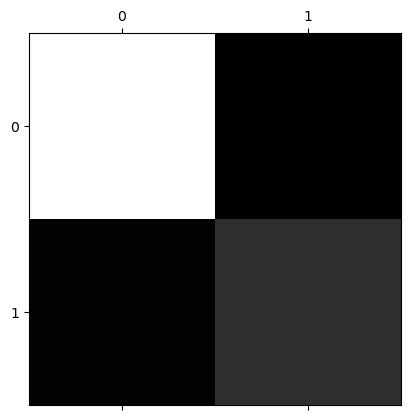

In [78]:
# Consider the confusion matrix for the sgd_clf classifier
import matplotlib.pyplot as plt

class AssessModel:
    def __init__(self, model, features, labels):
        self.model = model
        self.features = features
        self.labels = labels
        self.labels_pred = None
        self.conf_mat = None
        
    def cvp(self):
        self.labels_pred = crossValPredict(self.model, self.features, self.labels)
        self.conf_mat = confusion_matrix(self.labels, self.labels_pred)
        
    def precision(self):
        return "Precision = %.5f"%precision_score(self.labels, self.labels_pred)
    
    def recall(self):
        return "Recall = %.5f"%recall_score(self.labels, self.labels_pred)
    
sgd_clf_performance = AssessModel(sgd_clf, X_train, y_train)
sgd_clf_performance.cvp()
print(sgd_clf_performance.precision())
print(sgd_clf_performance.recall())

plt.matshow(sgd_clf_performance.conf_mat, cmap=plt.cm.gray)
print(sgd_clf_performance.conf_mat); plt.show();

#### Random Forest Classifier

In [84]:
rf_clf = RandomForestClassifier(random_state=1,n_estimators=5)
rf_clf.fit(X_train, y_train)

RandomForestClassifier(n_estimators=5, random_state=1)

In [85]:
crossValScores(rf_clf, X_train, y_train)

array([1., 1., 1., 1., 1.])

Precision = 1.00000
Recall = 1.00000
[[1993    0]
 [   0  407]]


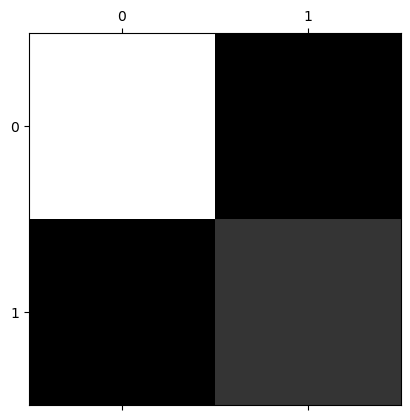

In [86]:
rf_clf_perf = AssessModel(rf_clf, X_train, y_train)
rf_clf_perf.cvp()
print(rf_clf_perf.precision())
print(rf_clf_perf.recall())

plt.matshow(rf_clf_perf.conf_mat, cmap = plt.cm.gray)
print(rf_clf_perf.conf_mat); plt.show()

#### Support Vector Machine Classifier

In [87]:
svm_clf = SVC(random_state=10)
svm_clf.fit(X_train, y_train)
svm_clf.predict([X_train.iloc[12]]) == y_train.iloc[12]

/home/colin/.local/lib/python3.10/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(


array([ True])